# Apple Quality Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality')
df = pd.read_csv('apple-quality/apple_quality.csv')

Skipping, found downloaded files in ".\apple-quality" (use force=True to force download)


In [3]:
# Setting a seed
np.random.seed(1337)


In [4]:
# Drop NA values
df = df.dropna()

# Get info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 312.5+ KB


In [5]:
# Convert to float
df['Quality'] = df['Quality'].map({'good': 1, 'bad': 0})
df['Acidity'] = df['Acidity'].astype("float")

# Delete useless information
df.drop("A_id", axis=1, inplace=True)

In [6]:
df.describe()
# Seems a bit weird why would size be -7, dataset is most likely already scaled

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877,0.501000
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270,0.500062
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538,0.000000
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424,0.000000
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609,1.000000
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493,1.000000
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736,1.000000


# Visualization 

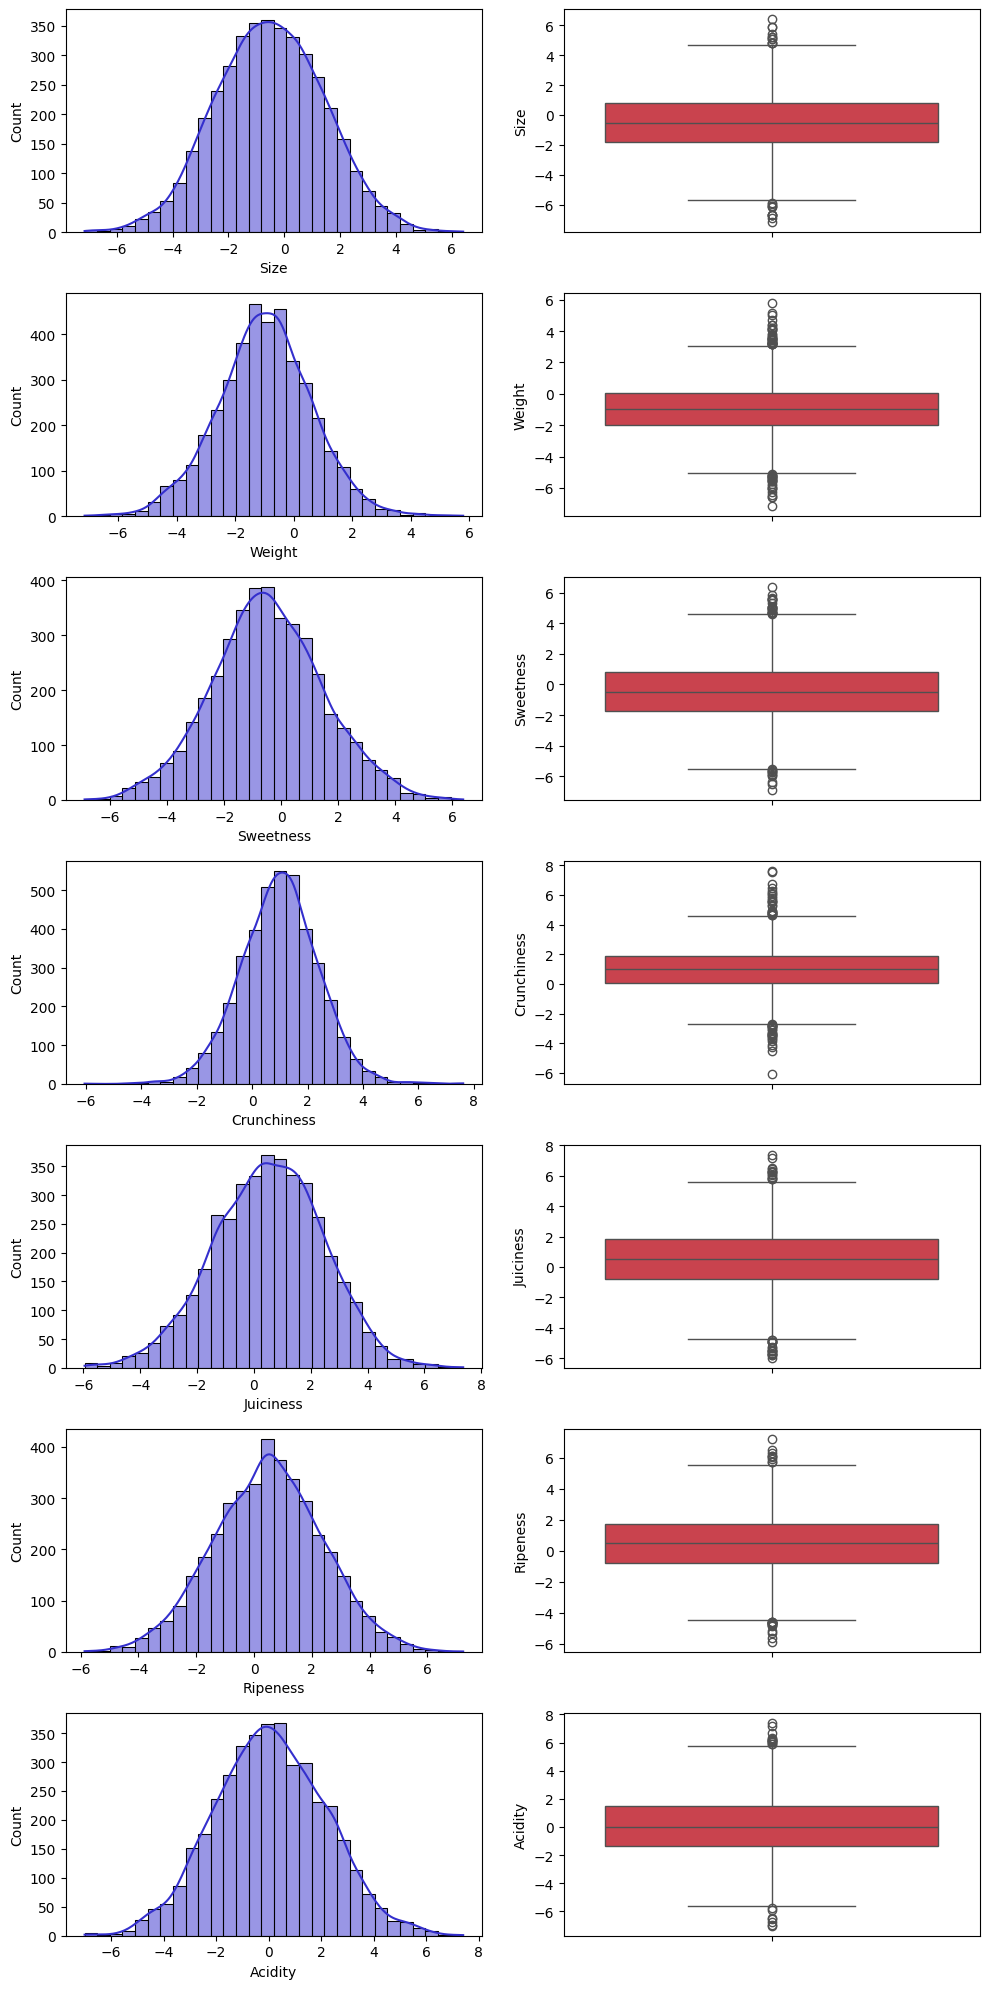

In [7]:
# Visualizing dataset
fig, axs = plt.subplots(7, 2 , figsize=(10, 20))

# creating the plots
for i, col in enumerate(df.select_dtypes("number").columns):
    # Max number of col
    if i == 7:break
    sns.histplot(df, x=col, ax=axs[i, 0], bins=30, kde=True, color="#342FCD") 
    sns.boxplot(df, y=col, ax=axs[i, 1], color="#DF2D3B")
plt.tight_layout()
plt.show()

What we can see is that we have lots of outliers in our datset mainly looking at the describe function as well as the the boxplots

In [8]:
X = df.drop("Quality", axis=1)
y = df["Quality"]

In [9]:
# Transforming
X_new = QuantileTransformer().fit_transform(X)
X_old = X

['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']


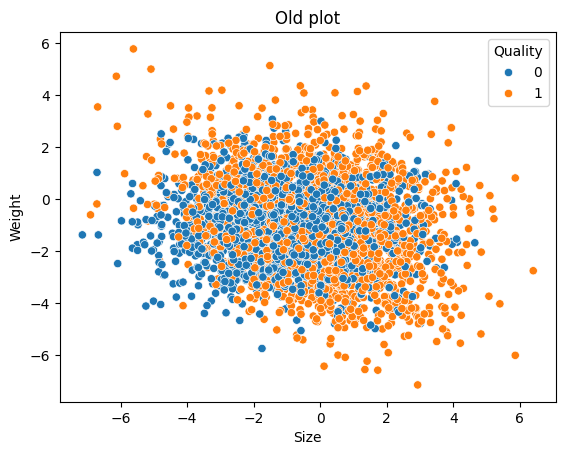

In [10]:
# Scatter a plot
sns.scatterplot(x="Size", y="Weight", hue=y, data=X_old)
plt.title('Old plot')
print(X_old.columns.tolist())

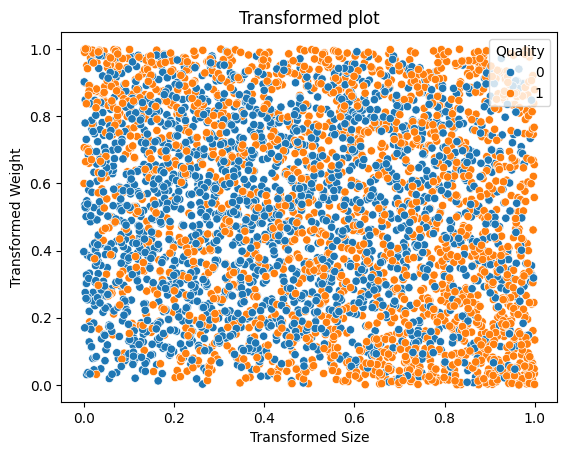

In [11]:
# Scatter a plot
sns.scatterplot(x=X_new[:, 0], y=X_new[:, 1], hue=y, legend='full')
plt.legend(loc='upper right', title='Quality')
plt.title('Transformed plot')
plt.xlabel('Transformed Size')
plt.ylabel('Transformed Weight')
plt.show()

# Heatmap

<Axes: >

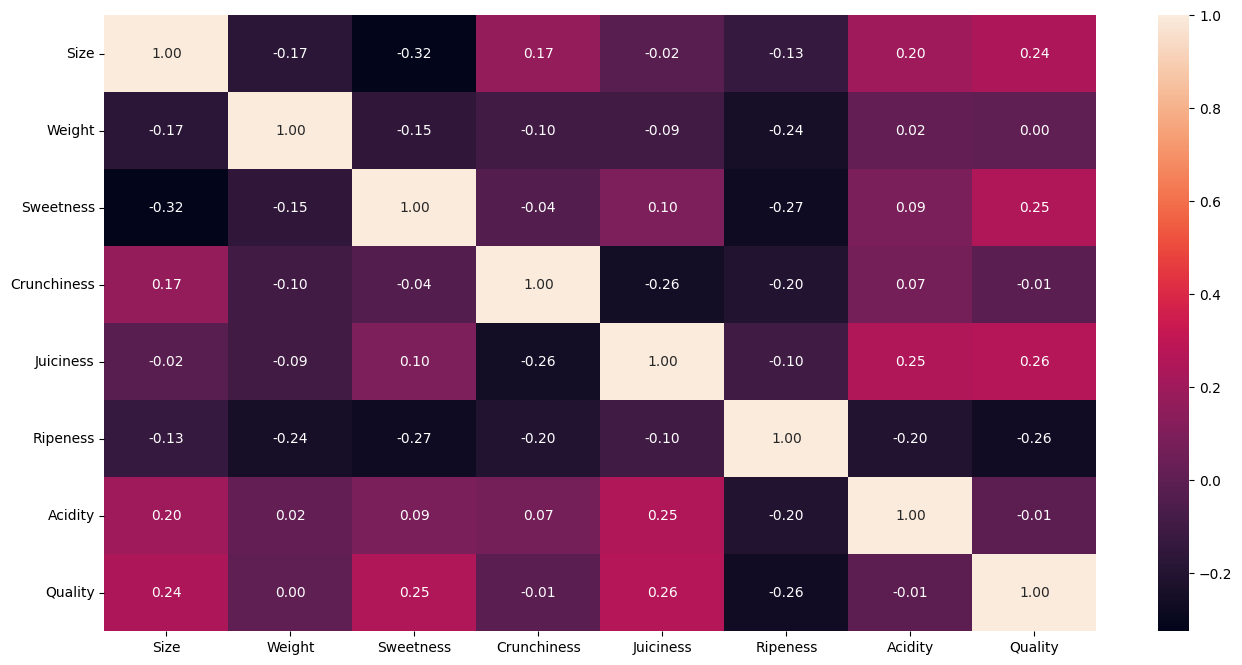

In [12]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

# Lets test multicollinearity with VIF 

In [13]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the data VIF
print(vif_data)

       feature       VIF
0         Size  1.296660
1       Weight  1.604642
2    Sweetness  1.425089
3  Crunchiness  1.371320
4    Juiciness  1.215703
5     Ripeness  1.579338
6      Acidity  1.171249


# Models

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=1337)
pipe = Pipeline([
        ("model", LogisticRegression()),

])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

accuracy_score(y_test, pred)

0.749

In [15]:
pipe = Pipeline([
        ("model", RandomForestClassifier(random_state=1337))
])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

accuracy_score(y_test, pred)

0.887

In [16]:
pipe = Pipeline([
        ("model", KNeighborsClassifier())
])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

accuracy_score(y_test, pred)

0.909

In [17]:
# Creating function to find the best scaler
def best_scaler(classifier):
    print(classifier)
    scalers = [
        ('None', None),
        ('StandardScaler', StandardScaler()),
        ('RobustScaler', RobustScaler()),
        ('QuantileTransformer', QuantileTransformer()),
        ('MinMaxScaler', MinMaxScaler())
    ]
    results = {}
    for scaler_name, scaler in scalers:
        pipeline = Pipeline([
            ('scaler', scaler),
            ('classifier', classifier)
        ])
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
        results[scaler_name] = scores.mean()
    return results

In [18]:
best_scaler(RandomForestClassifier(random_state=1337))

RandomForestClassifier(random_state=1337)


{'None': 0.882,
 'StandardScaler': 0.882,
 'RobustScaler': 0.882,
 'QuantileTransformer': 0.8826666666666666,
 'MinMaxScaler': 0.882}

In [19]:
best_scaler(LogisticRegression())

LogisticRegression()


{'None': 0.7483333333333333,
 'StandardScaler': 0.748,
 'RobustScaler': 0.748,
 'QuantileTransformer': 0.7243333333333333,
 'MinMaxScaler': 0.7433333333333334}

In [20]:
best_scaler(KNeighborsClassifier())

KNeighborsClassifier()


{'None': 0.8893333333333334,
 'StandardScaler': 0.8870000000000001,
 'RobustScaler': 0.8866666666666667,
 'QuantileTransformer': 0.8779999999999999,
 'MinMaxScaler': 0.8883333333333333}

# Improving our models

In [21]:
# Pipeline
pipe = Pipeline([
    ("polynomial", PolynomialFeatures( include_bias=False)),
    ("model", LogisticRegression(max_iter=1000))
])

# Parameters to check
param_grid = {
    "polynomial__degree": [1, 2, 3],
    "model__C": [ 0.1, 0.5, 1],
}


grid = GridSearchCV(
    estimator=pipe,  
    param_grid=param_grid,  
    cv=5,  
    scoring='accuracy'
)

grid.fit(X_train, y_train)

pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_polynomial__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006263,0.000707,0.001201,4.004002e-04,0.1,1,"{'model__C': 0.1, 'polynomial__degree': 1}",0.756667,0.746667,0.740000,0.750000,0.743333,0.747333,0.005735,9
1,0.019818,0.000400,0.001401,4.902129e-04,0.1,2,"{'model__C': 0.1, 'polynomial__degree': 2}",0.868333,0.861667,0.841667,0.856667,0.865000,0.858667,0.009333,4
2,0.105496,0.004804,0.002002,3.814697e-07,0.1,3,"{'model__C': 0.1, 'polynomial__degree': 3}",0.896667,0.891667,0.866667,0.893333,0.901667,0.890000,0.012156,2
3,0.005605,0.000491,0.001201,4.003049e-04,0.5,1,"{'model__C': 0.5, 'polynomial__degree': 1}",0.758333,0.746667,0.741667,0.750000,0.743333,0.748000,0.005907,8
4,0.020418,0.001857,0.001602,4.904465e-04,0.5,2,"{'model__C': 0.5, 'polynomial__degree': 2}",0.870000,0.858333,0.836667,0.856667,0.865000,0.857333,0.011382,5
5,0.139127,0.005296,0.001802,4.004480e-04,0.5,3,"{'model__C': 0.5, 'polynomial__degree': 3}",0.896667,0.886667,0.865000,0.896667,0.898333,0.888667,0.012534,3
6,0.007407,0.001021,0.001201,4.003288e-04,1,1,"{'model__C': 1, 'polynomial__degree': 1}",0.758333,0.746667,0.743333,0.750000,0.743333,0.748333,0.005578,7
7,0.021019,0.000633,0.001401,4.905049e-04,1,2,"{'model__C': 1, 'polynomial__degree': 2}",0.870000,0.858333,0.836667,0.856667,0.865000,0.857333,0.011382,5
8,0.156743,0.010792,0.001802,4.004717e-04,1,3,"{'model__C': 1, 'polynomial__degree': 3}",0.896667,0.886667,0.865000,0.898333,0.905000,0.890333,0.013960,1


In [22]:
Grid = GridSearchCV(
    estimator=KNeighborsClassifier(),  
    param_grid={'n_neighbors': [3, 5, 7, 9],
               'weights':['uniform', 'distance']},
    cv=5, 
    scoring='accuracy'
)
Grid.fit(X_train, y_train)

pd.DataFrame(Grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004004,1.507891e-07,0.026824,1.166883e-03,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.911667,0.868333,0.895000,0.883333,0.881667,0.888000,0.014545,6
1,0.004004,3.568323e-07,0.007607,4.901740e-04,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.910000,0.868333,0.895000,0.883333,0.881667,0.887667,0.014008,7
2,0.004003,4.370285e-07,0.027825,4.000189e-04,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.910000,0.870000,0.893333,0.890000,0.883333,0.889333,0.013064,3
3,0.004004,4.156970e-07,0.009008,3.504023e-07,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.911667,0.870000,0.893333,0.891667,0.883333,0.890000,0.013622,2
4,0.004004,4.156970e-07,0.028626,4.903297e-04,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.906667,0.871667,0.890000,0.886667,0.886667,0.888333,0.011155,4
5,0.004004,3.234067e-07,0.009809,4.002810e-04,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.908333,0.875000,0.891667,0.890000,0.886667,0.890333,0.010719,1
6,0.004004,3.234067e-07,0.029226,4.005432e-04,9,uniform,"{'n_neighbors': 9, 'weights': 'uniform'}",0.901667,0.865000,0.891667,0.895000,0.883333,0.887333,0.012632,8
7,0.003803,4.000904e-04,0.010410,4.902324e-04,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",0.900000,0.868333,0.891667,0.895000,0.886667,0.888333,0.010904,4


 # Voting Classifier

In [25]:
# LogisticRegression pipeline
logreg_pipe = Pipeline([
    ("polynomial", PolynomialFeatures(degree=3, include_bias=False)),
    ("model", LogisticRegression(C=0.1, max_iter=1000))
])

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('knn', KNeighborsClassifier(n_neighbors=7, weights='distance')), ('logreg', logreg_pipe), ('rf', RandomForestClassifier(random_state=1337))],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

pred = voting_clf.predict(X_test)

accuracy_score(y_test, pred)

0.906

In [26]:
print('Thank you :)')

Thank you :)
